# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [199]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [200]:
from common_utils import MLP, split_dataset, preprocess_dataset, CustomDataset, loss_fn
import pandas as pd

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df,['filename','label'],0.3,1)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [201]:
from common_utils import EarlyStopper

def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    # YOUR CODE HERE

    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=0)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    times = []

    for t in range(100):
        print(f"Epoch {t+1}\n-------------------------------")
        start = time.time()

        # Training Loop
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_accuracies.append(train_acc), train_losses.append(train_loss)
        end = time.time()
        times.append(end-start)

        # Validation Loop        
        test_loss, test_acc = test_loop(val_dataloader, model, loss_fn)
        test_accuracies.append(test_acc), test_losses.append(test_loss)

        if early_stopper.early_stop(test_loss):
            print("Early stopping")
            return train_accuracies, train_losses, test_accuracies, test_losses, times

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [202]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    cross_validation_accuracies = []
    cross_validation_times = []

    for parameter in parameters:
        print(f"Parameter {parameter}")
        accuracies = []
        times = []
        for train_index, val_index in kf.split(X_train):
            X_train2, X_val2 = X_train[train_index], X_train[val_index]
            y_train2, y_val2 = y_train[train_index], y_train[val_index]
            
            if mode == 'num_neurons':
                model = MLP(77,parameter,1)
            else:
                break

            train_accuracies, train_losses, test_accuracies, test_losses, time = train(model, X_train2, y_train2, X_val2, y_val2, batch_size)
            accuracies.append(test_accuracies[-1])
            times.append(time[-1])
            
        cross_validation_accuracies.append(np.mean(accuracies))
        cross_validation_times.append(np.mean(times))

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 256. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = 256
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, 'num_neurons', optimal_bs)

Parameter 64
Epoch 1
-------------------------------
loss: 0.692708  [  256/ 6751]
Train Error: 
 Accuracy: 52.4%, Avg loss: 0.690163 

Test Error: 
 Accuracy: 54.7%, Avg loss: 0.684965 

Epoch 2
-------------------------------
loss: 0.678608  [  256/ 6751]
Train Error: 
 Accuracy: 56.0%, Avg loss: 0.681287 

Test Error: 
 Accuracy: 57.2%, Avg loss: 0.675351 

Epoch 3
-------------------------------
loss: 0.675470  [  256/ 6751]
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.671743 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.665913 

Epoch 4
-------------------------------
loss: 0.664471  [  256/ 6751]
Train Error: 
 Accuracy: 60.7%, Avg loss: 0.660527 

Test Error: 
 Accuracy: 58.1%, Avg loss: 0.671577 

Epoch 5
-------------------------------
loss: 0.631929  [  256/ 6751]
Train Error: 
 Accuracy: 61.4%, Avg loss: 0.651543 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.660651 

Epoch 6
-------------------------------
loss: 0.652682  [  256/ 6751]
Train Error: 
 Accuracy: 62.1%, Avg loss: 

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

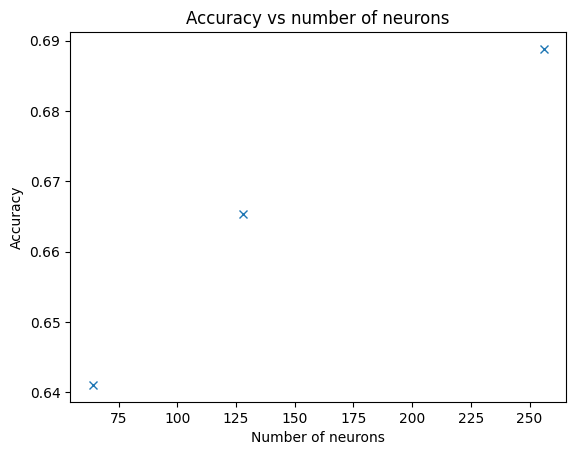

In [203]:
# YOUR CODE HERE

plt.plot(num_neurons, cross_validation_accuracies, marker='x', linestyle='None')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of neurons')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [204]:
optimal_neurons = 256
reason = ""
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [205]:
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [206]:
input_features = X_train_scaled.shape[1]
no_labels = 1
final_model = MLP(input_features,optimal_neurons,no_labels)
optimal_bs = 256

train_accuracies, train_losses, test_accuracies, test_losses, times = train(final_model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

# save the model
torch.save(final_model.state_dict(), 'model.pt')

Epoch 1
-------------------------------
loss: 0.691643  [  256/ 8439]
Train Error: 
 Accuracy: 55.1%, Avg loss: 0.686106 

Test Error: 
 Accuracy: 56.9%, Avg loss: 0.678986 

Epoch 2
-------------------------------
loss: 0.678645  [  256/ 8439]
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.668306 

Test Error: 
 Accuracy: 58.8%, Avg loss: 0.668322 

Epoch 3
-------------------------------
loss: 0.651561  [  256/ 8439]
Train Error: 
 Accuracy: 61.6%, Avg loss: 0.652012 

Test Error: 
 Accuracy: 61.3%, Avg loss: 0.656216 

Epoch 4
-------------------------------
loss: 0.616534  [  256/ 8439]
Train Error: 
 Accuracy: 64.3%, Avg loss: 0.630297 

Test Error: 
 Accuracy: 61.4%, Avg loss: 0.651440 

Epoch 5
-------------------------------
loss: 0.658798  [  256/ 8439]
Train Error: 
 Accuracy: 65.9%, Avg loss: 0.616708 

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.635535 

Epoch 6
-------------------------------
loss: 0.595508  [  256/ 8439]
Train Error: 
 Accuracy: 67.6%, Avg loss: 0.593894 

Te

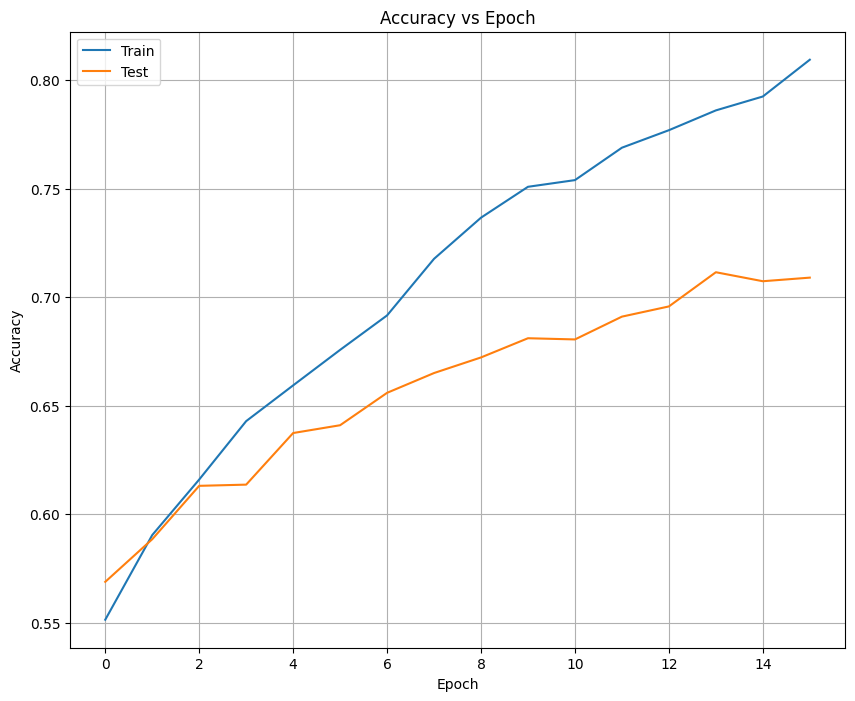

In [207]:
# YOUR CODE HERE
plt.figure(figsize=(10,8))
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.grid(True)
plt.legend()